In [1]:
import pandas as pd

In [2]:
train_df = pd.read_csv("../data/train.csv")
val_df = pd.read_csv("../data/val.csv")
test_df = pd.read_csv("../data/test.csv")

print("train size", len(train_df))
print("val size", len(val_df))
print("test size", len(test_df))

train size 31255
val size 3473
test size 8682


In [3]:
train_df.sample(10)

,text,label
17844,She said that? Wtf?? That's fucked up. I shoul...,1
30841,to 6:30. Does that look fake to you?,0
16451,Gamers know all too well how it feels to be op...,0
27141,that tease tonight lowered my hopes,1
22674,And Tyler Rodriguez solid one-word sentences,0
5426,He made it !!!,0
17949,"Speaking of /u/'s ""If your nips aren't leaky.....",0
25453,Thank you and I try to keep our contact at a m...,0
26164,Me cheering for the Wild this year,0
13283,Still pissed we didn’t hire Kyle Shaw. He woul...,0


<AxesSubplot:>

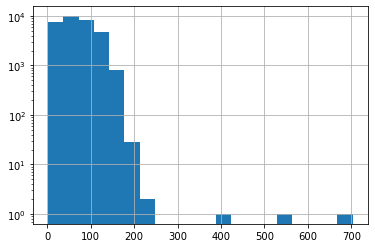

In [18]:
length_dist = train_df["text"].apply(len)
length_dist.hist(log=True, bins=20)

In [5]:
train_df.groupby("label").count()

,text
label,
0,24718
1,6537


In [6]:
train_neg = train_df[train_df["label"] == 0]
train_pos = train_df[train_df["label"] == 1]

train_neg

,text,label
0,takes no time to copy/paste a press release,0
2,Jazz fan here. I completely feel. Lindsay Mann...,0
3,ah i was also confused but i think they mean f...,0
4,Thank you so much. ♥️ that means a lot.,0
5,And I’ll be there!!!,0
...,...,...
31250,thank you so much! :),0
31251,That works too. To each their own.,0
31252,"Friendly fire dude, I wanted the other criminal",0
31253,"Yes, exactly. Fix a date and if he still procr...",0


In [7]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('punkt')

en_stopwords = stopwords.words('english')
en_stopwords[:10]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Thien\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Thien\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [8]:
en_stopwords = set(en_stopwords)

In [9]:
def count_unigram(texts):
    vocab = {}

    for x in texts:
        words = x.lower().split()
        for w in words:
            if w not in en_stopwords:
                vocab[w] = vocab.get(w,0) + 1

    vocab = pd.DataFrame.from_dict(vocab, orient="index", columns=["count"])
    vocab.sort_values("count", ascending=False, inplace=True)
    
    return vocab

pos_unigram = count_unigram(train_pos["text"])
neg_unigram = count_unigram(train_neg["text"])

In [10]:
pos_unigram.T

,like,i'm,people,get,sorry,even,really,one,think,would,...,times!,gift,idiots....sheep,thinkers,changes,chemist.,remind,goddamit.,redpiller,dummy
count,509,348,321,285,254,233,231,228,213,212,...,1,1,1,1,1,1,1,1,1,1


In [11]:
neg_unigram.T

,like,love,would,i'm,get,good,one,think,people,really,...,janitors,icu.,minnesota?,reciprocal,rinds?,sullivan.,apparantly,boomhauer(?)(boom-how-er),stealthy,"least,"
count,1784,1258,1008,1007,961,961,907,812,779,770,...,1,1,1,1,1,1,1,1,1,1


Data is clean and does not need any cleaning. 



In [15]:
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier

In [24]:
tokenized_train = tokenizer(train_df["text"].to_list(), max_length=512, truncation=True, padding=True)
tokenized_val = tokenizer(val_df["text"].to_list(), max_length=512, truncation=True, padding=True)
tokenized_test = tokenizer(test_df["text"].to_list(), max_length=512, truncation=True, padding=True)

In [25]:
tokenized_train.keys()

dict_keys(['input_ids', 'attention_mask'])

In [26]:
import torch
from torch.utils.data import Dataset

class TextDataset(Dataset):
    def __init__(self, tokenized_text, labels):
        self.tokenized_text = tokenized_text
        self.labels = labels
    
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k,v in self.tokenized_text.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
    
train_dataset = TextDataset(tokenized_train, train_df["label"].to_list())
val_dataset = TextDataset(tokenized_val, val_df["label"].to_list())
test_dataset = TextDataset(tokenized_test, test_df["label"].to_list())

In [27]:
train_dataset[0]

{'input_ids': tensor([  101,  3138,  2053,  2051,  2000,  6100,  1013, 19351,  1037,  2811,
          2713,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 

In [ ]:
training_args = TrainingArguments(
    output_dir="results",
    logging_dir="logs"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

trainer.train()

Step,Training Loss
